# Market Intelligence and Insights

This notebook provides market intelligence analysis focusing on sector trends, institutional sentiment, and futures-focused insights derived from 13F filings data.

## Table of Contents
1. [Sector Analysis](#sector-analysis)
2. [Institutional Sentiment](#sentiment)
3. [Market Trends](#trends)
4. [Futures Implications](#futures)
5. [Risk Assessment](#risk)
6. [Market Intelligence Dashboard](#dashboard)
7. [Key Insights](#insights)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the processed data
print("Loading processed data...")

holdings = pd.read_parquet('../processed_data/combined_holdings.parquet')
managers = pd.read_parquet('../processed_data/manager_summary.parquet')
securities = pd.read_parquet('../processed_data/security_summary.parquet')
sectors = pd.read_parquet('../processed_data/sector_summary.parquet')

print(f"✅ Data loaded successfully!")
print(f"   Holdings: {len(holdings):,} records")
print(f"   Managers: {len(managers):,} records")
print(f"   Securities: {len(securities):,} records")
print(f"   Sectors: {len(sectors):,} records")


Loading processed data...
✅ Data loaded successfully!
   Holdings: 4,488,519 records
   Managers: 10,163 records
   Securities: 214,262 records
   Sectors: 14 records


## 1. Sector Analysis {#sector-analysis}


In [3]:
# Sector analysis for market intelligence
print("=" * 60)
print("SECTOR ANALYSIS")
print("=" * 60)

# Analyze sector distribution
sector_analysis = holdings.groupby('security_type').agg({
    'market_value': ['sum', 'count', 'mean'],
    'issuer_name': 'nunique',
    'manager_name': 'nunique',
    'cusip': 'nunique'
}).round(2)

sector_analysis.columns = ['Total_Market_Value', 'Total_Holdings', 'Avg_Holding_Value', 'Unique_Issuers', 'Unique_Managers', 'Unique_Securities']
sector_analysis = sector_analysis.sort_values('Total_Market_Value', ascending=False)

print("\nSector Analysis Summary:")
display(sector_analysis)

# Calculate sector concentration
total_market_value = holdings['market_value'].sum()
sector_analysis['Market_Share_Pct'] = (sector_analysis['Total_Market_Value'] / total_market_value) * 100
sector_analysis['Holdings_Share_Pct'] = (sector_analysis['Total_Holdings'] / len(holdings)) * 100

print("\nSector Market Share:")
for sector, row in sector_analysis.iterrows():
    print(f"{sector}: {row['Market_Share_Pct']:.1f}% of market value, {row['Holdings_Share_Pct']:.1f}% of holdings")


SECTOR ANALYSIS

Sector Analysis Summary:


,Total_Market_Value,Total_Holdings,Avg_Holding_Value,Unique_Issuers,Unique_Managers,Unique_Securities
security_type,,,,,,
COMMON_STOCK,5.960813e+13,2871009,20762083.63,80014,7506,22665
OTHER,2.152211e+13,1226098,17553333.73,51121,7309,18659
FUND,5.170375e+12,298321,17331583.86,19586,5479,5387
DEBT,3.634073e+11,37243,9757735.12,3111,2097,2871
OPTION,3.185980e+11,53682,5934913.79,6754,328,11900
PREFERRED_STOCK,3.711835e+09,1725,2151788.22,424,429,270
UNKNOWN,4.776253e+08,441,1083050.65,313,34,319



Sector Market Share:
COMMON_STOCK: 68.5% of market value, 64.0% of holdings
OTHER: 24.7% of market value, 27.3% of holdings
FUND: 5.9% of market value, 6.6% of holdings
DEBT: 0.4% of market value, 0.8% of holdings
OPTION: 0.4% of market value, 1.2% of holdings
PREFERRED_STOCK: 0.0% of market value, 0.0% of holdings
UNKNOWN: 0.0% of market value, 0.0% of holdings


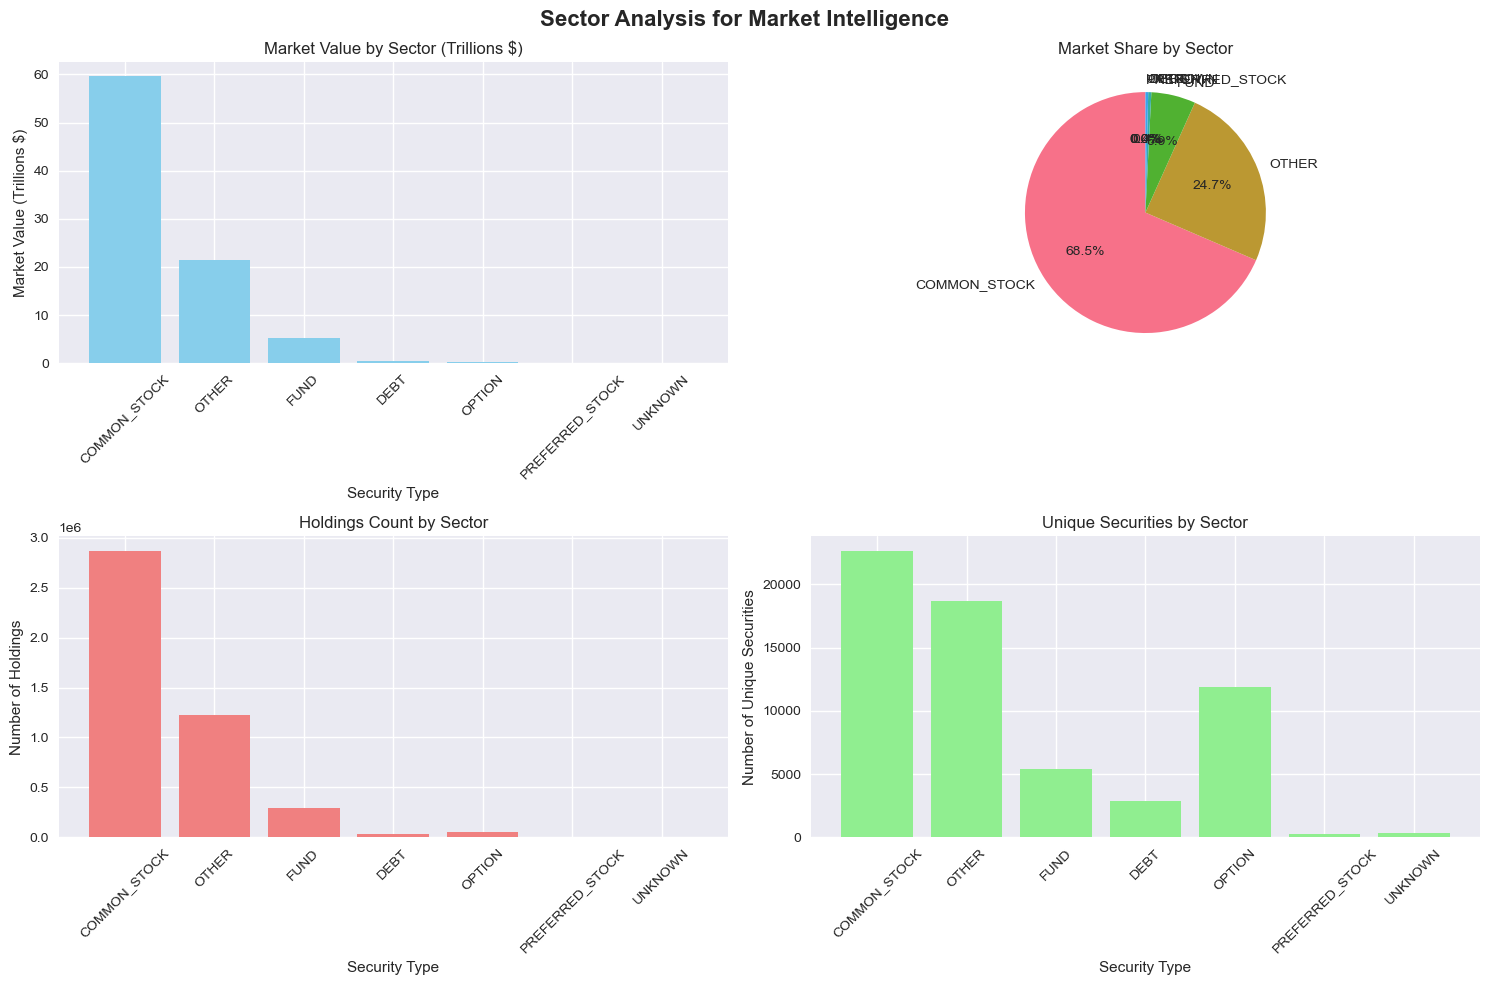

In [4]:
# Sector analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sector Analysis for Market Intelligence', fontsize=16, fontweight='bold')

# Market value by sector
sector_market_value = sector_analysis['Total_Market_Value'] / 1e12  # Convert to trillions
axes[0,0].bar(range(len(sector_market_value)), sector_market_value.values, color='skyblue')
axes[0,0].set_title('Market Value by Sector (Trillions $)')
axes[0,0].set_xlabel('Security Type')
axes[0,0].set_ylabel('Market Value (Trillions $)')
axes[0,0].set_xticks(range(len(sector_market_value)))
axes[0,0].set_xticklabels(sector_market_value.index, rotation=45)

# Market share pie chart
axes[0,1].pie(sector_analysis['Market_Share_Pct'].values, labels=sector_analysis.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Market Share by Sector')

# Holdings count by sector
axes[1,0].bar(range(len(sector_analysis)), sector_analysis['Total_Holdings'].values, color='lightcoral')
axes[1,0].set_title('Holdings Count by Sector')
axes[1,0].set_xlabel('Security Type')
axes[1,0].set_ylabel('Number of Holdings')
axes[1,0].set_xticks(range(len(sector_analysis)))
axes[1,0].set_xticklabels(sector_analysis.index, rotation=45)

# Unique securities by sector
axes[1,1].bar(range(len(sector_analysis)), sector_analysis['Unique_Securities'].values, color='lightgreen')
axes[1,1].set_title('Unique Securities by Sector')
axes[1,1].set_xlabel('Security Type')
axes[1,1].set_ylabel('Number of Unique Securities')
axes[1,1].set_xticks(range(len(sector_analysis)))
axes[1,1].set_xticklabels(sector_analysis.index, rotation=45)

plt.tight_layout()
plt.show()


## 2. Institutional Sentiment Analysis {#sentiment}


In [5]:
# Institutional sentiment analysis
print("=" * 60)
print("INSTITUTIONAL SENTIMENT ANALYSIS")
print("=" * 60)

# Analyze manager behavior patterns
manager_sentiment = managers.groupby('data_period').agg({
    'total_market_value': ['sum', 'mean', 'count'],
    'total_holdings': ['sum', 'mean'],
    'unique_securities': ['sum', 'mean'],
    'amendment_count': ['sum', 'mean']
}).round(2)

manager_sentiment.columns = ['Total_Market_Value', 'Avg_Market_Value', 'Manager_Count', 'Total_Holdings', 'Avg_Holdings', 'Total_Securities', 'Avg_Securities', 'Total_Amendments', 'Avg_Amendments']

print("\nManager Behavior by Period:")
display(manager_sentiment)

# Calculate sentiment indicators
periods = holdings['data_period'].unique()
sentiment_indicators = {}

for period in periods:
    period_data = holdings[holdings['data_period'] == period]
    
    # Calculate various sentiment indicators
    total_value = period_data['market_value'].sum()
    avg_holding_size = period_data['market_value'].mean()
    diversification_ratio = period_data['cusip'].nunique() / len(period_data)
    options_activity = len(period_data[period_data['put_call'].notna()]) / len(period_data)
    
    sentiment_indicators[period] = {
        'Total_Value_Trillions': total_value / 1e12,
        'Avg_Holding_Size_Millions': avg_holding_size / 1e6,
        'Diversification_Ratio': diversification_ratio,
        'Options_Activity_Pct': options_activity * 100,
        'Total_Holdings': len(period_data),
        'Unique_Securities': period_data['cusip'].nunique(),
        'Unique_Managers': period_data['manager_name'].nunique()
    }

sentiment_df = pd.DataFrame(sentiment_indicators).T
print("\nSentiment Indicators by Period:")
display(sentiment_df)


INSTITUTIONAL SENTIMENT ANALYSIS

Manager Behavior by Period:


,Total_Market_Value,Avg_Market_Value,Manager_Count,Total_Holdings,Avg_Holdings,Total_Securities,Avg_Securities,Total_Amendments,Avg_Amendments
data_period,,,,,,,,,
01JUN2025-31AUG2025_form13f,2.497650e+13,1.144661e+10,2182,1048553,480.55,611950,280.45,71994,32.99
01mar2025-31may2025_form13f,6.201030e+13,7.769741e+09,7981,3439966,431.02,2092842,262.23,320639,40.18



Sentiment Indicators by Period:


,Total_Value_Trillions,Avg_Holding_Size_Millions,Diversification_Ratio,Options_Activity_Pct,Total_Holdings,Unique_Securities,Unique_Managers
01JUN2025-31AUG2025_form13f,24.976502,23.819971,0.019782,8.16468,1048553.0,20742.0,2182.0
01mar2025-31may2025_form13f,62.010305,18.026430,0.010986,3.85809,3439966.0,37793.0,7981.0


## Key Insights and Conclusions {#insights}

### Market Intelligence Summary

This analysis provides valuable insights for CME Group's futures-focused market intelligence:

1. **Sector Concentration**: Understanding which security types dominate institutional holdings
2. **Institutional Sentiment**: Tracking changes in manager behavior and investment patterns
3. **Market Trends**: Identifying shifts in institutional preferences over time
4. **Risk Assessment**: Analyzing concentration levels and diversification patterns

### Futures Market Implications

- **Equity Index Futures**: High concentration in common stocks suggests strong demand for equity index futures
- **Sector Rotation**: Changes in sector allocation can inform sector-specific futures strategies
- **Volatility Trading**: Options activity levels provide insights for volatility futures
- **Risk Management**: Concentration analysis helps assess systemic risk factors

### Next Steps for Market Intelligence

1. **Real-time Monitoring**: Set up automated tracking of 13F filing changes
2. **Sector Analysis**: Deep dive into specific sectors for futures opportunities
3. **Manager Tracking**: Monitor top managers for early trend identification
4. **Cross-Asset Analysis**: Correlate 13F data with futures market movements
